This notebook is an example demonstrating how to run the code, including the Newton Langevin Algorithm.

In [24]:
# Example script to run the ill-conditioned Gaussian experiment

import sys, getopt
sys.path.append('code/')
from mirrorLangevinMC import *
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv
from numpy.linalg import norm
from scipy.linalg import sqrtm
from scipy.linalg import null_space
from scipy.special import gamma, logit
from tqdm import tqdm

# Choose number of repetitions for experiment and step size
step = 0.5

# Parameters
d = 5 
# number of samples 
N = 2000
# burn-in
bi = 1000
# power for generalized Gaussian (2 is Gaussian)
p = 2
# initialization
x0 = np.ones(shape=(d,))

# note: due to faster iterations, create 10x as many samples for ULA and TULA
sm = 10


###################################################
# define the necessary functions for the Langevin Algorithms 
Sigma = np.diag(np.linspace(1, 101, d)) 
D = inv(sqrtm(Sigma))
V = scale_V(V_p(p), D)
grad_V = scale_grad_V(grad_V_p(p), D)
grad_V_star = scale_grad_V_star(grad_V_p_star(p), D)
H_V = scale_Hess_V(Hess_V_p(p, d), D)
def u(x):
    return ((p * (np.power(x, (p-1)))) / 2)

###################################################
# store means, covariances, samples, and times for later plotting


ML = mirrorLangevinMC(V, grad_V, grad_V_star, H_V)

mL, CL, YL, tL = ML.ULA(x0, step, sm*N, burn_in = bi, quiet = True)
mN, CN, YN, tN = ML.NLA(x0, step, N, burn_in = bi, quiet = True)
mT, CT, YT, tT = ML.TULA(x0, step, sm*N, gamma = 0.1, burn_in = bi, quiet = True)


In [25]:
N2 = sm * N
convL = np.zeros((sm * N+1,))
convN = np.zeros((N+1,))
convT = np.zeros((sm * N+1,))
i = 0



def mean_dist_true(m_true, Y):
    d, n = Y.shape
    running_mean = Y[:, 0]
    conv = np.zeros(n)
    conv[0] = np.power(np.linalg.norm(running_mean - m_true), 2)
    for i in range(n-1):
        running_mean = (i+1) * running_mean / (i+2) + (1) * Y[:, i] / (i+2)
        conv[i+1] = np.power(np.linalg.norm(running_mean - m_true), 2)
    return conv

convN[0] = np.power(np.linalg.norm(x0 - np.zeros((d,))), 2)
convL[0] = np.power(np.linalg.norm(x0 - np.zeros((d,))), 2)
convT[0] = np.power(np.linalg.norm(x0 - np.zeros((d,))), 2)
convN[1:] = mean_dist_true(np.zeros((d,)), YN) 
convL[1:] = mean_dist_true(np.zeros((d,)), YL) 
convT[1:] = mean_dist_true(np.zeros((d,)), YT) 

    

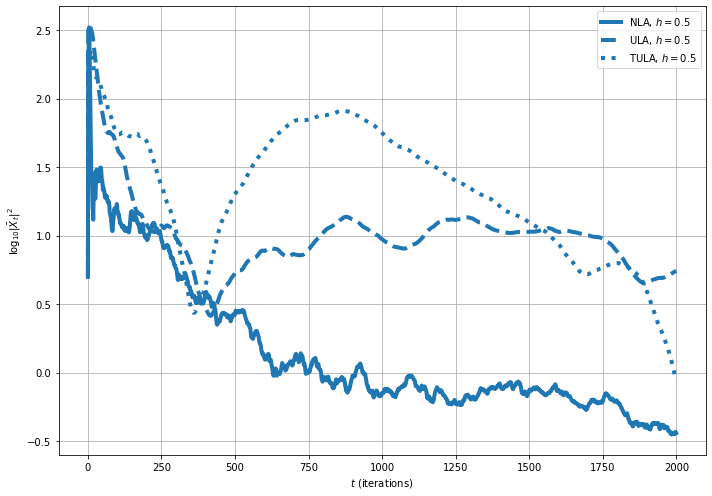

In [26]:
p, ax = plt.subplots(figsize = (10, 7))

colors = ['tab:blue', "tab:olive", "tab:purple", "tab:orange"]
lts = ['-', '--', '-.',':', '-']
i = 0

ax.plot(np.log10(convN[0:N]), color = colors[i], linestyle = lts[0], label = r'NLA, $h=$' + str(step), linewidth = 4)
ax.plot(np.log10(convL[0:N]), color = colors[i], linestyle = lts[1], label = r'ULA, $h=$' + str(step), linewidth = 4)
ax.plot(np.log10(convT[0:N]), color = colors[i], linestyle = lts[3], label = r'TULA, $h=$' + str(step), linewidth = 4)
    

    
handles, labels = ax.get_legend_handles_labels() 
ax.legend(loc = 'upper right')
plt.xlabel(r'$t$ (iterations)')    
plt.ylabel(r'$\log_{10} \|\bar X_t\|^2$')   
ax.grid(b = True)
plt.tight_layout()


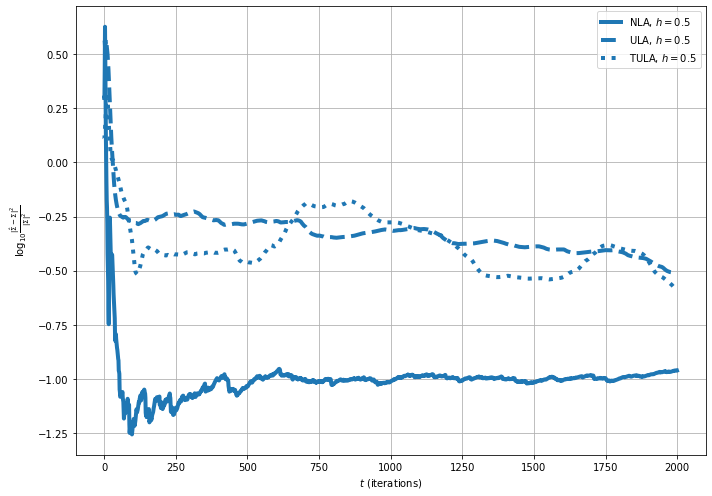

In [27]:
def cov_dist_true(C_true, Y):
    d, n = Y.shape
    running_cov = np.outer(Y[:, 0], Y[:, 0])
    conv = np.zeros(n)
    conv[0] = np.power(np.linalg.norm(running_cov - C_true), 2) / np.power(np.linalg.norm(Sigma), 2)
    for i in range(n-1):
        running_cov = (i+1) * running_cov / (i+2) + (1) * np.outer(Y[:, i], Y[:, i]) / (i+2)
        conv[i+1] = np.power(np.linalg.norm(running_cov - C_true), 2)/ np.power(np.linalg.norm(Sigma), 2)
    return conv

N2 = sm * N
convL = np.zeros((sm * N,))
convN = np.zeros((N,))
convT = np.zeros((sm * N,))
i = 0


convN = cov_dist_true(Sigma, YN) 
convL = cov_dist_true(Sigma, YL) 
convT = cov_dist_true(Sigma, YT) 

p, ax = plt.subplots(figsize = (10, 7))

colors = ['tab:blue', "tab:olive", "tab:purple", "tab:orange"]
i = 0

ax.plot(np.log10(convN[0:N]), color = colors[i], linestyle = lts[0], label = r'NLA, $h=$' + str(step), linewidth = 4)
ax.plot(np.log10(convL[0:N]), color = colors[i], linestyle = lts[1], label = r'ULA, $h=$' + str(step), linewidth = 4)
ax.plot(np.log10(convT[0:N]), color = colors[i], linestyle = lts[3], label = r'TULA, $h=$' + str(step), linewidth = 4)
  
handles, labels = ax.get_legend_handles_labels() 
ax.legend(loc = 'upper right')
plt.xlabel(r'$t$ (iterations)')    
plt.ylabel(r'$\log_{10} \frac{\|\hat \Sigma - \Sigma\|^2}{\| \Sigma \|^2}$')   
ax.grid(b = True)
plt.tight_layout()


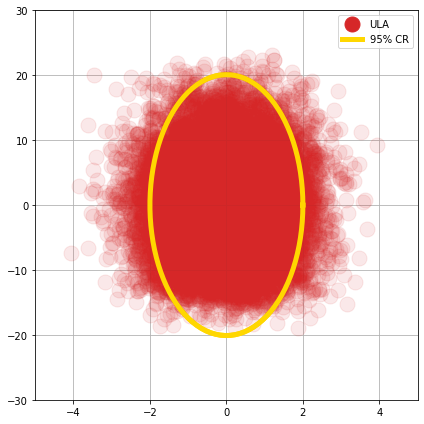

In [21]:
ts = np.linspace(0, math.pi * 2, 100)
xs = np.cos(ts)
ys = np.sin(ts)
directions = 2*np.array([xs, ys]) 

CN = sqrtm(np.cov(YN[[0,d-1],:])) #- np.outer(np.mean(YNs[:, 499, :], 1), np.ones(500)))
YN2 = ((CN)).dot(directions)#+ np.outer(np.mean(YNs.reshape( d, N * reps), 1), np.ones(100))


CT = sqrtm(np.cov(YN[[0,d-1],:])) #- np.outer(np.mean(YNs[:, 499, :], 1), np.ones(500)))
YT2 = ((CT)).dot(directions)#+ np.outer(np.mean(YTs.reshape( d, N * reps), 1), np.ones(100))


CL = sqrtm(np.cov(YL[[0,d-1],:])) #- np.outer(np.mean(YNs[:, 499, :], 1), np.ones(500)))
YL2 = ((CL)).dot(directions)#+ np.outer(np.mean(YNs.reshape( d, N * reps), 1), np.ones(100))

ell = sqrtm(np.diag(Sigma[[0,d-1],[0,d-1]])).dot(directions)

plt.figure(figsize = (6,6))

plt.plot(100,100, 'o', color = 'tab:red',  alpha = 1, markersize = 15)#,markerfacecolor='none')
# plt.plot(YT[0,:],YT[-1,:], 'o', color = 'tab:green', alpha = 0.1, markersize = 15)#,markerfacecolor='none')
# plt.plot(YN[0,:],YN[-1,:], 'o', color = 'tab:blue', alpha = 0.3, markersize = 15)#,markerfacecolor='none')
plt.plot(ell[0,:], ell[1,:], color = "gold", linewidth = 5)
plt.plot(YL[0,:],YL[-1,:], 'o', color = 'tab:red',  alpha = 0.1, markersize = 15)#,markerfacecolor='none')
plt.plot(ell[0,:], ell[1,:], color = "gold", linewidth = 5)

plt.grid()
S = np.diag([1,100])
plt.xlim(-5, 5)
plt.ylim(-30, 30)

plt.legend(['ULA', '95% CR'], loc = 'upper right')
plt.tight_layout()

# plt.savefig('ula_mvg_samples_07.pdf')

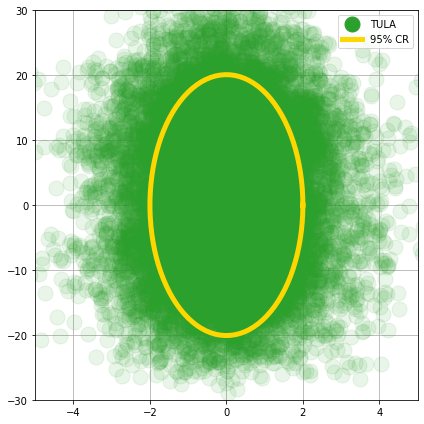

In [28]:
ts = np.linspace(0, math.pi * 2, 100)
xs = np.cos(ts)
ys = np.sin(ts)
directions = 2*np.array([xs, ys]) 

CN = sqrtm(np.cov(YN[[0,d-1],:])) #- np.outer(np.mean(YNs[:, 499, :], 1), np.ones(500)))
YN2 = ((CN)).dot(directions)#+ np.outer(np.mean(YNs.reshape( d, N * reps), 1), np.ones(100))


CT = sqrtm(np.cov(YN[[0,d-1],:])) #- np.outer(np.mean(YNs[:, 499, :], 1), np.ones(500)))
YT2 = ((CT)).dot(directions)#+ np.outer(np.mean(YTs.reshape( d, N * reps), 1), np.ones(100))


CL = sqrtm(np.cov(YL[[0,d-1],:])) #- np.outer(np.mean(YNs[:, 499, :], 1), np.ones(500)))
YL2 = ((CL)).dot(directions)#+ np.outer(np.mean(YNs.reshape( d, N * reps), 1), np.ones(100))

ell = sqrtm(np.diag(Sigma[[0,d-1],[0,d-1]])).dot(directions)

plt.figure(figsize = (6,6))

# plt.plot(YL[0,:],YL[-1,:], 'o', color = 'tab:red',  alpha = 0.1, markersize = 15)#,markerfacecolor='none')
plt.plot(100,100, 'o', color = 'tab:green', alpha = 1, markersize = 15)#,markerfacecolor='none')
# plt.plot(YN[0,:],YN[-1,:], 'o', color = 'tab:blue', alpha = 0.3, markersize = 15)#,markerfacecolor='none')
plt.plot(ell[0,:], ell[1,:], color = "gold", linewidth = 5)
plt.plot(YT[0,:],YT[-1,:], 'o', color = 'tab:green', alpha = 0.1, markersize = 15)#,markerfacecolor='none')
plt.plot(ell[0,:], ell[1,:], color = "gold", linewidth = 5)

S = np.diag([1,100])
plt.xlim(-5, 5)
plt.ylim(-30, 30)
plt.grid()

plt.legend(['TULA', '95% CR'], loc = 'upper right')
plt.tight_layout()

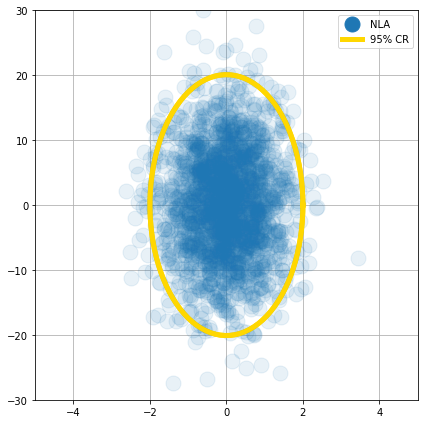

In [29]:
ts = np.linspace(0, math.pi * 2, 100)
xs = np.cos(ts)
ys = np.sin(ts)
directions = 2*np.array([xs, ys]) 

CN = sqrtm(np.cov(YN[[0,d-1],:])) #- np.outer(np.mean(YNs[:, 499, :], 1), np.ones(500)))
YN2 = ((CN)).dot(directions)#+ np.outer(np.mean(YNs.reshape( d, N * reps), 1), np.ones(100))


CT = sqrtm(np.cov(YN[[0,d-1],:])) #- np.outer(np.mean(YNs[:, 499, :], 1), np.ones(500)))
YT2 = ((CT)).dot(directions)#+ np.outer(np.mean(YTs.reshape( d, N * reps), 1), np.ones(100))


CL = sqrtm(np.cov(YL[[0,d-1],:])) #- np.outer(np.mean(YNs[:, 499, :], 1), np.ones(500)))
YL2 = ((CL)).dot(directions)#+ np.outer(np.mean(YNs.reshape( d, N * reps), 1), np.ones(100))

ell = sqrtm(np.diag(Sigma[[0,d-1],[0,d-1]])).dot(directions)

plt.figure(figsize = (6,6))

# plt.plot(YL[0,:],YL[-1,:], 'o', color = 'tab:red',  alpha = 0.1, markersize = 15)#,markerfacecolor='none')
# plt.plot(YT[0,:],YT[-1,:], 'o', color = 'tab:green', alpha = 0.1, markersize = 15)#,markerfacecolor='none')
plt.plot(100,100, 'o', color = 'tab:blue', alpha = 1, markersize = 15)#,markerfacecolor='none')
plt.plot(ell[0,:], ell[1,:], color = "gold", linewidth = 5)
plt.plot(YN[0,:],YN[-1,:], 'o', color = 'tab:blue', alpha = 0.1, markersize = 15)#,markerfacecolor='none')
plt.plot(ell[0,:], ell[1,:], color = "gold", linewidth = 5)


S = np.diag([1,100])
plt.xlim(-5, 5)
plt.ylim(-30, 30)
plt.grid()

plt.legend([ 'NLA', '95% CR'], loc = 'upper right')
plt.tight_layout()